<div style='background-color: darkblue; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 10% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Geodynamik und Geothermie</div>
            <div style="font-size: large ; padding-top: 10px ; color: rgba(0 , 0 , 0 , 0.5)">Übung 2 -- Wegener, Peppel, Schultz, Heck</div>
        </div>
    </div>
</div>


# Kommentiertes Programm
Es soll die Planetenbewegung im Zweidimensionalen um die Sonne mittels eines geschriebenen Programmes visualisiert werden. Wir haben Python benutzt, um die Bahnen der Planeten Venus, Erde und Jupiter, welche sich um die Sonne bewegen, zu simulieren. Das Programm wurde in einzelne Funktionen gegliedert, um es in einzelnen Schritten testen zu können und leichter veränderbar zu sein.



In [21]:
from typing import Tuple
from numpy import sqrt
import matplotlib.pyplot as plt

# Plotting configuration
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 10

Das Programm wurde objektorientiert geschrieben. Jedes Objekt ist eine Instanz der Klasse _Particle_. Gemäß der physikalischen Realität besitzt jedes Objekt eine Position, Geschwindigkeit und Masse. Außerdem ordnen wir einen Namen und eine Farbe zum darstellen zu. 
Für jede Zustandsgröße gibt es eine _return_-Funktion, die jeweils den gewollten Wert ausgibt. 

In [22]:
class Particle():
    def __init__(self, name, pos_x, pos_y, vel_x, vel_y, mass, color='blue') -> None:
        self.name = name
        self.pos_x = pos_x
        self.pos_y = pos_y
        self.vel_x = vel_x
        self.vel_y = vel_y
        self.mass = mass
        self.force_x = 0.0
        self.force_y = 0.0
        self.color = color
    
    # Funktion zum Zurückgeben der Kraft in x- und y-Richtung
    def get_force(self) -> Tuple:
        return (self.force_x, self.force_y)

    # Funktion zum Zurückgeben der Position in x- und y-Richtung
    def get_position(self) -> Tuple:
        return (self.pos_x, self.pos_y)

    # Funktion zum Zurückgeben der Geschwindigkeit in x- und y-Richtung
    def get_velocity(self) -> Tuple:
        return (self.vel_x, self.vel_y)

    # Funktion zum Zurückgeben der Beschleunigung in x- und y-Richtung, a = F/m
    def get_acceleration(self) -> Tuple:
        return (self.force_x/self.mass, self.force_y/self.mass)

Zur Berechnung der gesamt wirkenden Kraft auf einen Körper wird das Gravitationsgesetz benutzt. Man teilt die Kraft in ihre Komponenten auf, um eindimensionale Größen zu erhalten.

In [23]:
# Funktion zum Berechnen der Kraft in x- und y-Richtung
def calc_force(objects) -> None:
    G = 6.67e-11  # Gravitationskonstante, N · m2 / kg2
    for object in objects:
        # Anfangskraft auf Körper = 0
        object.force_x = 0
        object.force_y = 0

        # Jeder Nachbarkörper übt eine Gravitationskraft auf den betrachteten Körper aus
        for neighbor in objects:
            if neighbor != object:  # Für jeden anderen Körper (Nachbarn), der nicht der betrachtete Körper selber ist
                # Absolute Gravitationskraft des Nachbarkörpers auf den betrachteten Körper
                force = G * object.mass * neighbor.mass / ((object.pos_x - neighbor.pos_x)**2 + 
                                                           (object.pos_y - neighbor.pos_y)**2)
                # Richtung der Kraft in x- und y-Richtung. Folgt geometrisch.
                direction = (-(object.pos_x - neighbor.pos_x), - (object.pos_y - neighbor.pos_y))
                alpha = direction[0]/direction[1]
                # Addition der Kraftkomponenten eines Nachbarn zur gesamtwirkenden Kraft auf den betrachteten Körper
                object.force_x += (-(object.pos_x - neighbor.pos_x) / 
                                   abs((object.pos_x - neighbor.pos_x))) * force/sqrt(1+1/(alpha**2))
                object.force_y += (-(object.pos_y - neighbor.pos_y) / 
                                   abs((object.pos_y - neighbor.pos_y))) * force/sqrt(1+alpha**2)



Zum Berechnen der neuen Geschwindigkeit `v` zu jedem Zeitschritt mit der Länge `dt` wird benutzt, dass `F = m * a` bzw. `a = F/m` und `a = v * dt` gilt, also `v = F/m * dt`.
Jede Kraftänderung führt zu einer Geschwindigkeitsänderung, welche die vorherige Geschwindigkeit beeinflusst. Daher ist die neue Geschwindigkeit, die Alte plus die Änderung über die Zeit `dt`

In [24]:
# Funktion zum Berechnen der Geschwindigkeit in x- und y-Richtung nach Zeitschritt dt unter gegebenen Kraft 
def calc_velocity(objects, dt) -> None:
    for object in objects:
        object.vel_x += (object.force_x/object.mass) * dt
        object.vel_y += (object.force_y/object.mass) * dt

Außerdem wird noch die Position nach jedem Zeitschritt `dt` benötigt. Dabei wird ausgenutzt, dass sich die Strecke `pos` in jedem Zeitschritt `dt` näherungsweise linear ändert mit `pos = v * dt`. Dies gilt nicht mehr, wenn zwei Körper sehr dicht beieinander sind bzw. sehr große Beschleunigungen wirken. In dem aktuellen Problem betrachten wir aber die Bewegung der Planeten um die Sonne. Wenn man den Zeitschritt `dt` also hinreichend klein wählt, kann man eine lineare Änderung der Strecke annehmen, da sich zwei Planeten nicht so dicht kommen.

Jede Positionsänderung wird auf die vorherige Position hinzuaddiert.

In [25]:
# Funktion zum Berechnen der Position in x- und y-Richtung
def calc_position(objects, dt) -> None:
    for object in objects:
        object.pos_x += object.vel_x * dt
        object.pos_y += object.vel_y * dt

Mit der Funktion `simulation()` wird die Simulation durchgeführt. Für jeden Körper wird zu jedem Zeitschritt die aufeinanderwirkende Kraft und die daraus resultierende Positionsänderung berechnet.

In [26]:
# Funktion zur Simulation des Problems
def simulation(objects, dt, timesteps):
    memory = [[] for object in objects]
    for t in range(timesteps):
        calc_force(objects)
        calc_velocity(objects, dt)
        calc_position(objects, dt)
        for i in range(len(objects)):
            memory[i].append(objects[i].get_position())
    return memory

Mit der Funktion `plotting()` werden die Positionen dann geplottet:

In [27]:
def plotting(data, render_points, string, legend, answ='no'):
    plt.figure()
    for object in data:
        plt.plot([i[0] for i in object[::len(object)//render_points]], [i[1] for i in object[::len(object)//render_points]])
    plt.xlabel('x Position [m]', fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel('y Position [m]', fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(string, fontsize=16, fontweight='bold')
    plt.legend(legend)
    if answ != 'no':
        plt.axis([-0.025e11, 0.025e11, -0.025e11, 0.025e11])
    plt.show()

Das Programm ist objektorientiert geschrieben, wobei das Objekt particles ist. In diesem Objekt sind der Name, die x- und y- Position, x- und y-Geschwindigkeit und Masse festgelegt und ihm wird eine Farbe zugeordnet. Benutzt wurden die Planeten Venus (Amore), Erde (Dirt) und Jupiter (Gas) mit den folgenden Eigenschaften:

- Amore = Venus, 1.08e11 m, 4.875e24 kg ; 3.5e4 m/s
- Dirt = Erde, 1.496e11 m ; 5.97e24 kg ; 3e4 m/s
- Gas = Jupiter, 6.64e14 m ; 1,898e27 kg ; 1.303e4 m/s

und die Sonne mit Position (0,0), Anfangsgeschwindigkeit (0,0) und Masse 1.99e30 kg

In [28]:
# Betrachtete Körper
# Particle(Name, pos_x, pos_y, vel_x, vel_y, m, Farbe)
particles_all = [Particle("Sol", 0, 0, 0, 0, 1.99e30, 'orange'),
             Particle('Amore', 1.08e11, 2, 0, 3.5e4, 4.875e24, 'magenta'),
             Particle("Dirt", 1.496e11, 1, 0, 3e4, 5.97e24, 'blue'),
             Particle("Gas", 6.64e11, 3, 0, 1.303e4, 1.898e27, 'cyan')]

particles_earth = [Particle("Sol", 0, 0, 0, 0, 1.99e30, 'orange'), Particle("Dirt", 1.496e11, 1, 0, 3e4, 5.97e24, 'blue')]

particles_ear_ven = [Particle("Sol", 0, 0, 0, 0, 1.99e30, 'orange'), Particle("Dirt", 1.496e11, 1, 0, 3e4, 5.97e24, 'blue'), 
                     Particle('Amore', 1.08e11, 2, 0, 3.5e4, 4.875e24, 'magenta')]

Zur Durchführung der Simulation werden die Zeitschrittgröße, der insgesamt betrachtete Zeitraum und für das Plotten noch die Anzahl der Renderpoints benötigt. Es wird eine Zeitschrittgröße von einem Erdtag gewählt, ein Zeitraum von 2 Erdjahren und eine Renderpointgröße von 600 points:

In [29]:
dt = 86400  # Länge eines Zeitschritts
timesteps = 365*2  # Insgesamter betrachteter Zeitraum
render_points = 365*2  # Render Points zum Plotten

Zum Ausführen und plotten der Simulation, werden nun die Funktionen simulation() und plotting() gerufen:

In [30]:
data = simulation(particles_earth, dt, timesteps)
plotting(data, render_points, 'Umlaufbahn Erde für zwei Erdenjahren um die Sonne', [i.name for i in particles_earth])

In diesem Plot ist dargestellt, wie die sich die Erde um die Sonne bewegt, wenn nur die Gravitationskraft der Sonne auf sie wirkt.

In [31]:
data = simulation(particles_ear_ven, dt, timesteps)
plotting(data, render_points, 'Umlaufbahnen der Erde und Venus für zwei Erdenjahren um die Sonne', [i.name for i in particles_ear_ven])

In diesem Plot ist dargestellt, wie sich Erde und Venus um die Sonne bewegen

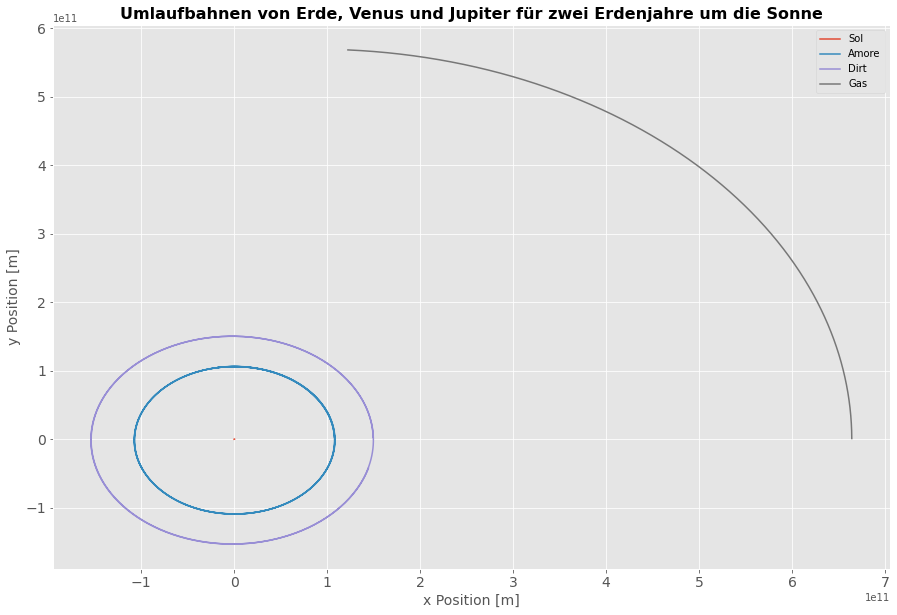

In [32]:
data = simulation(particles_all, dt, timesteps)
plotting(data, render_points, 'Umlaufbahnen von Erde, Venus und Jupiter für zwei Erdenjahre um die Sonne', [i.name for i in particles_all])

Und in diesem Plot wie sich zusätzlich noch der Jupiter um die Sonne bewegt

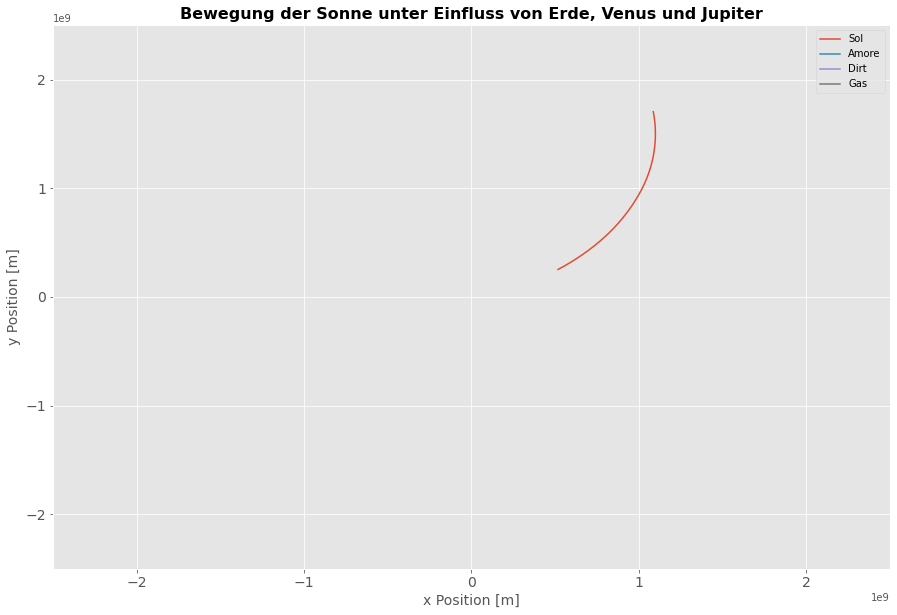

In [33]:
data = simulation(particles_all, dt, timesteps)
plotting(data, render_points, 'Bewegung der Sonne unter Einfluss von Erde, Venus und Jupiter', [i.name for i in particles_all], answ='yes')

Es ist deutlich zu erkennen, dass die Sonne nicht stabil im Zentrum bleibt, sondern durch die Planeten mitbewegt wird.

# Diskussion
Die Planeten bewegen sich in der Simulation näherungsweise auf Ellipsen, dessen Zentrum auf lange Zeit gesehen wandert. Dass sich die Planeten näherungsweise auf Ellipsen bewegen stimmt auch mit der Realität überein. Jedoch ist es in der Realität noch deutlich Komplexer: Monde und andere Planeten beeinflussen die Bahn der Planeten deutlich. Auch die Sonne im Zentrum wird nicht durch die Planeten dauerhaft in eine Richtung abgelenkt, sondern auch zurück.

Die Simulation vernachlässigt weitere vorhandene Körper neben den betrachteten, welche sich im Sonnensystem befinden und Kräfte ausüben.

# Gesamter Code

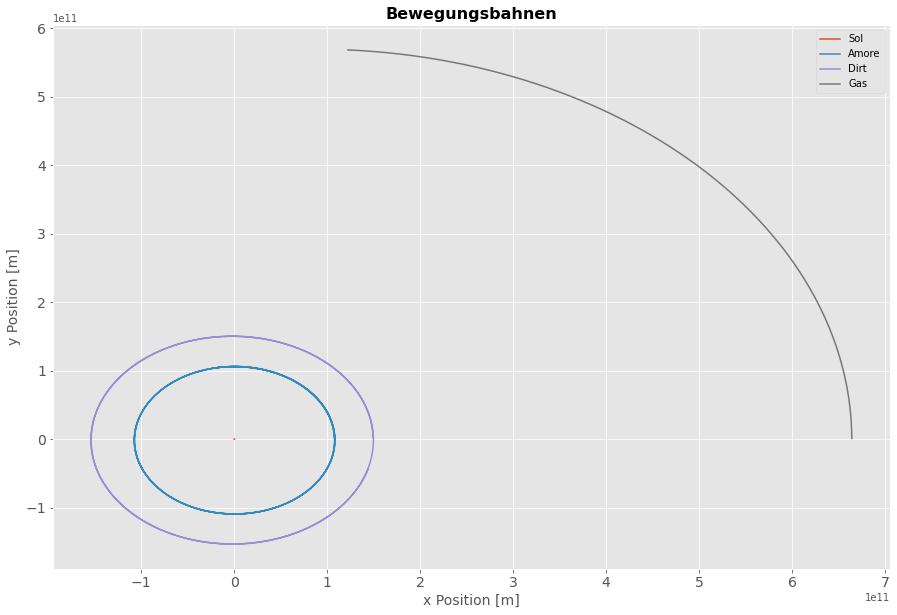

In [34]:
from typing import Tuple
from numpy import sqrt
import matplotlib.pyplot as plt

# Plotting configuration
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 10


class Particle():
    # init Funktion der Klasse
    def __init__(self, name, pos_x, pos_y, vel_x, vel_y, mass, color='blue') -> None:
        self.name = name
        self.pos_x = pos_x
        self.pos_y = pos_y
        self.vel_x = vel_x
        self.vel_y = vel_y
        self.mass = mass
        self.force_x = 0.0
        self.force_y = 0.0
        self.color = color

    # Funktion zum Zurückgeben der Kraft in x- und y-Richtung
    def get_force(self) -> Tuple:
        return (self.force_x, self.force_y)

    # Funktion zum Zurückgeben der Position in x- und y-Richtung
    def get_position(self) -> Tuple:
        return (self.pos_x, self.pos_y)

    # Funktion zum Zurückgeben der Geschwindigkeit in x- und y-Richtung
    def get_velocity(self) -> Tuple:
        return (self.vel_x, self.vel_y)

    # Funktion zum Zurückgeben der Beschleunigung in x- und y-Richtung, a = F/m
    def get_acceleration(self) -> Tuple:
        return (self.force_x/self.mass, self.force_y/self.mass)


# Funktion zum Berechnen der Kraft
def calc_force(objects) -> None:
    G = 6.67e-11  # Gravitationskonstante, N · m2 / kg2
    for object in objects:
        # Anfangskraft auf Körper = 0
        object.force_x = 0
        object.force_y = 0

        # Jeder weitere Körper übt die Gravitationskraft auf den betrachteten Körper aus
        for neighbor in objects:
            if neighbor != object:  # Für jeden anderen Körper, der nicht der betrachtete Körper selber ist
                # Gesamt ausgeübte Gravitationskraft der Nachbarkörper auf den betrachteten Körper
                force = G * object.mass * neighbor.mass / ((object.pos_x - neighbor.pos_x)**2 + 
                                                           (object.pos_y - neighbor.pos_y)**2)
                # Richtung der Kraft in x- und y-Richtung
                direction = (-(object.pos_x - neighbor.pos_x), - (object.pos_y - neighbor.pos_y))
                alpha = direction[0]/direction[1]
                # Berechnung der Kraft in x- und y-Richtung
                object.force_x += (-(object.pos_x - neighbor.pos_x) / abs((object.pos_x - 
                                                                           neighbor.pos_x))) * force/sqrt(1+1/(alpha**2))
                object.force_y += (-(object.pos_y - neighbor.pos_y) / abs((object.pos_y - 
                                                                           neighbor.pos_y))) * force/sqrt(1+alpha**2)


# Funktion zum Berechnen der Geschwindigkeit
def calc_velocity(objects, dt) -> None:
    # a = F/m, a = v/dt -> v = F/m * dt
    # Berechnung der Geschwindigkeit in x- und y-Richtung
    # Jede Kraftänderung führt zu einer Geschwindigkeitsänderung, welche die vorherige Geschwindigkeit beeinflusst.
    # Daher wird die neue Geschwindigkeit auf die alte drauf gerechnet
    for object in objects:
        object.vel_x += (object.force_x/object.mass) * dt
        object.vel_y += (object.force_y/object.mass) * dt


# Funktion zum Berechnen der Position
def calc_position(objects, dt) -> None:
    # Strecke = v * t -> pos = v * dt
    # Jede Positionsänderung wird auf die vorherige Position draufgerechnet
    for object in objects:
        object.pos_x += object.vel_x * dt
        object.pos_y += object.vel_y * dt

        
# Funktion zur Simulation des Problems
def simulation(objects, dt, timesteps):
    memory = [[] for object in objects]
    for t in range(timesteps):
        calc_force(objects)
        calc_velocity(objects, dt)
        calc_position(objects, dt)
        for i in range(len(objects)):
            memory[i].append(objects[i].get_position())
    return memory


# Funktion zum Plotten
def plotting(data, render_points, string, legend, answ='no'):
    plt.figure()
    for object in data:
        plt.plot([i[0] for i in object[::len(object)//render_points]], [i[1] for i in object[::len(object)//render_points]])
    plt.xlabel('x Position [m]', fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel('y Position [m]', fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(string, fontsize=16, fontweight='bold')
    plt.legend(legend)
    if answ != 'no':
        plt.axis([-0.025e11, 0.025e11, -0.025e11, 0.025e11])
    plt.show()
    

if __name__ == '__main__':
    
    # Betrachtete Körper
    # Particle(Name, pos_x, pos_y, vel_x, vel_y, m, Farbe)
    particles_all = [Particle("Sol", 0, 0, 0, 0, 1.99e30, 'orange'),
                     Particle('Amore', 1.08e11, 2, 0, 3.5e4, 4.875e24, 'magenta'),
                     Particle("Dirt", 1.496e11, 1, 0, 3e4, 5.97e24, 'blue'),
                     Particle("Gas", 6.64e11, 3, 0, 1.303e4, 1.898e27, 'cyan')]

    particles_earth = [Particle("Sol", 0, 0, 0, 0, 1.99e30, 'orange'), Particle("Dirt", 1.496e11, 1, 0, 3e4, 5.97e24, 'blue')]

    particles_ear_ven = [Particle("Sol", 0, 0, 0, 0, 1.99e30, 'orange'), 
                         Particle("Dirt", 1.496e11, 1, 0, 3e4, 5.97e24, 'blue'), 
                         Particle('Amore', 1.08e11, 2, 0, 3.5e4, 4.875e24, 'magenta')]

    # Festlegung Zeit
    dt = 86400
    timesteps = 365*2
    render_points = 365*2

    
    # Ausführen der Simulation
    data = simulation(particles_all, dt, timesteps)
    plotting(data, render_points, 'Bewegungsbahnen', [i.name for i in particles_all])